In [ ]:
!pip install --upgrade nbformat
!pip install --upgrade notebook ipykernel

In [ ]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from collections import Counter
import re

import nltk
# nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kujilit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('../data/analysis_results.csv')

df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.day_name()
df['hour'] = df['date'].dt.hour

In [6]:
sentiment_map = {'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1}
df['sentiment_value'] = df['sentiment'].map(sentiment_map)

In [7]:
fig_sentiment = px.line(
    df,
    x='date',
    y='sentiment_value',
    title='📈 Динамика настроения постов',
    markers=True,
    line_shape='spline',
    color_discrete_sequence=['#4E79A7']
)
fig_sentiment.update_layout(
    template='plotly_white',
    title_font_size=20,
    xaxis_title='Дата публикации',
    yaxis_title='Настроение (-1 → негатив, +1 → позитив)',
)
fig_sentiment.show()

In [ ]:
df = pd.read_csv('../data/analysis_results.csv')

texts = ' '.join(df['text'].dropna().astype(str))

words = re.findall(r'\b[а-яё]+\b', texts.lower())

# флюгегенхаймен
russian_stopwords = set(stopwords.words('russian'))

custom_stopwords = {
    'это', 'также', 'однако', 'свой', 'мочь', 'который',
    'наш', 'ваш', 'весь', 'много', 'сделать', 'ещё', 'где', 
    'один', 'другой', 'теперь', 'всё', 'будет', 'быть', 'делать', 'двфу', 'просто'
}

all_stopwords = russian_stopwords.union(custom_stopwords)


filtered_words = [
    w for w in words 
    if w not in all_stopwords and len(w) > 2  # убираем короткие слова
]



counts = Counter(filtered_words)
common_words = counts.most_common(100)  # реальные частоты
freq_dict = dict(common_words)

# Генерация облака (только для координат и цветов)
wc = WordCloud(
    width=800,
    height=400,
    max_words=100,
    background_color='white',
    colormap='cool',
    collocations=False
)
wc.generate_from_frequencies(freq_dict)

# Извлекаем позиции и цвета, но подставляем реальные частоты
word_positions = []
for (word, _), font_size, position, orientation, color in wc.layout_:
    x, y = position
    freq = freq_dict[word]  # берем настоящую частоту из Counter
    word_positions.append((word, freq, x, y, font_size, color))

wc_plot = pd.DataFrame(word_positions, columns=['word', 'freq', 'x', 'y', 'font_size', 'color'])


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=wc_plot['x'],
    y=-wc_plot['y'],
    text=wc_plot['word'],
    mode="text",
    textfont={
        "size": wc_plot['font_size'] / 3,
        "color": wc_plot['color']
    },
    hovertext=[f"{w} — {f} раз" for w, f in zip(wc_plot['word'], wc_plot['freq'])],
    hoverinfo="text"
))

fig.update_layout(
    title="☁️ Интерактивное облако смысловых слов",
    xaxis=dict(showgrid=False, showticklabels=False, zeroline=False),
    yaxis=dict(showgrid=False, showticklabels=False, zeroline=False),
    template="plotly_white",
    height=600
)

fig.show()

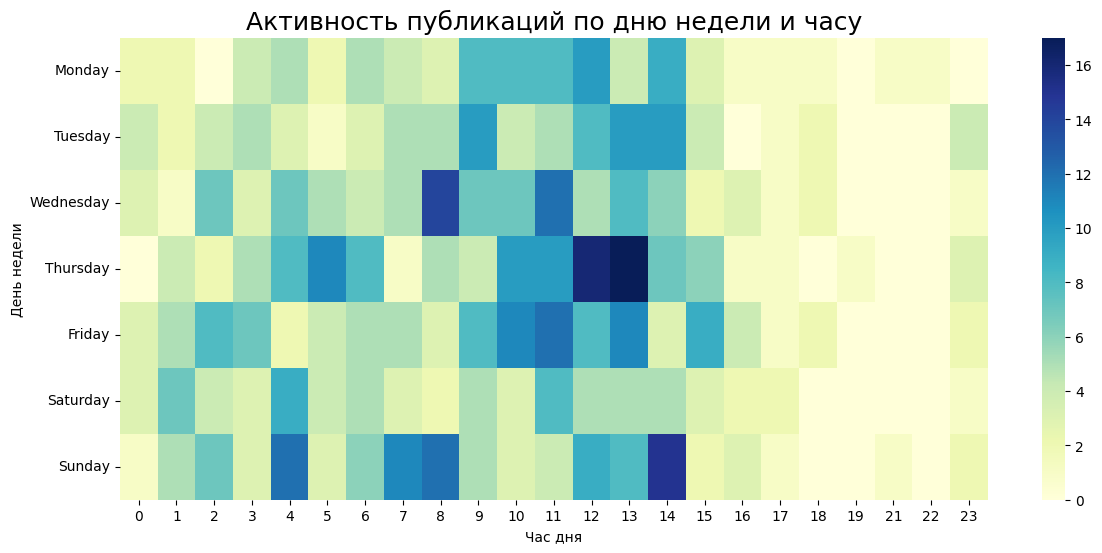

In [ ]:
# Считаем количество постов по дню недели и часу
pivot = df.pivot_table(index='day_of_week', columns='hour', values='text', aggfunc='count').fillna(0)

order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
pivot = pivot.reindex(order)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title('Активность публикаций по дню недели и часу', fontsize=18)
plt.xlabel('Час дня')
plt.ylabel('День недели')
plt.show()